In [91]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')

In [92]:
data = pd.read_csv('famcs_students.csv')

binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']

N = 12
y_col = binary_cols[N % 8]
print(f"Целевая переменная: {y_col}")

Целевая переменная: glasses


In [93]:
categorical_cols = ['cource', 'group', 'stream', 'sex', 'os', 'work_experience', 'ai', 
                    'social', 'sport', 'miss', 'foot_size', 'eye_color', 'retake', 'hostel']
numeric_cols = ['age', 'height', 'score']

mapping_dict = {
    'ss': {'Нет': 0, 'Да': 1},
    'interest': {'Математика': 0, 'Программирование': 1},
    'weekend_study': {'Нет': 0, 'Да': 1},
    'bad_sleep': {'Нет': 0, 'Да': 1},
    'glasses': {'Нет': 0, 'Да': 1},
    'study_form': {'Бюджет': 0, 'Платная': 1},
    'literature': {'Нет': 0, 'Да': 1},
    'anime': {'Нет': 0, 'Да': 1}
}

additional_binary_mapping = {
    'sex': {'М': 0, 'Ж': 1},
    'retake': {'0': 0, '1': 1, '2+': 2},  # Приводим к числу
    'hostel': {'Нет, я из Минска': 0, 'Нет, я из регионов': 0, 'Да': 1}
}

one_hot_cols = ['os', 'work_experience', 'ai', 'eye_color', 'cource', 'stream']

def normalize_column(col):
    return (col - col.mean()) / col.std()

processed_data = data.copy()

# Бинарные преобразования
for col, mapping in mapping_dict.items():
    if col in processed_data.columns:
        processed_data[col] = processed_data[col].map(mapping)
        
for col, mapping in additional_binary_mapping.items():
    if col in processed_data.columns:
        processed_data[col] = processed_data[col].map(mapping)

# One-hot encoding
for col in one_hot_cols:
    if col in processed_data.columns:
        dummies = pd.get_dummies(processed_data[col], prefix=col)
        processed_data = pd.concat([processed_data, dummies], axis=1)
        processed_data.drop(columns=[col], inplace=True)

# Нормализация числовых признаков
for col in numeric_cols:
    if col in processed_data.columns:
        processed_data[col] = normalize_column(processed_data[col])

# Удаляем ненужные колонки
processed_data.drop(columns=['group'], inplace=True)  # Группа не информативна для классификации

print("Конец")

Конец


In [94]:
# Оставляем только необходимые признаки (бинарные + обработанные)
X = processed_data.drop(columns=[y_col])
y = processed_data[y_col]
X = X.select_dtypes(include=[np.number])

print(f"Количество признаков после обработки: {X.shape[1]}")
print(f"Пример признаков: {X.columns.tolist()[:5]}")

# в X только числовые значения
assert not X.isnull().any().any(), "В признаках есть пропущенные значения!"

Количество признаков после обработки: 15
Пример признаков: ['sex', 'age', 'ss', 'interest', 'weekend_study']


In [95]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Размеры выборок после расширения признаков:")
print(f"Обучающая: {len(X_train)} (признаков: {X_train.shape[1]})")
print(f"Валидационная: {len(X_val)}")
print(f"Тестовая: {len(X_test)}")

Размеры выборок после расширения признаков:
Обучающая: 88 (признаков: 15)
Валидационная: 19
Тестовая: 20


In [96]:
class TrivialClassifier:
    def fit(self, X, y):
        # Определяем доминирующий класс
        self.most_common = int(y.value_counts(normalize=True).idxmax())
        
    def predict(self, X):
        return np.full(X.shape[0], self.most_common)

In [97]:
trivial = TrivialClassifier()
trivial.fit(X_train, y_train)
y_pred_trivial = trivial.predict(X_test)

In [98]:
# Наивный Байесовский классификатор
class BernoulliNaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.eps = 1e-10
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        
        # Вычисляем априорные вероятности
        self.class_priors = np.zeros(n_classes)
        for i, c in enumerate(self.classes):
            self.class_priors[i] = np.mean(y == c)
        
        # Вычисляем условные вероятности
        self.feature_probs = np.zeros((n_classes, n_features))
        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            # Сглаживание Лапласа
            self.feature_probs[i] = (np.sum(X_c, axis=0) + self.alpha) / (len(X_c) + 2*self.alpha)
        
        # Добавляем защиту от 0 и 1
        self.feature_probs = np.clip(self.feature_probs, self.eps, 1 - self.eps)
    
    def predict(self, X):
        return np.array([self._predict_single(x) for x in X])
    
    def _predict_single(self, x):
        posteriors = []
        for i, c in enumerate(self.classes):
            # Логарифмическая вероятность
            log_prior = np.log(self.class_priors[i])
            p = self.feature_probs[i]
            log_likelihood = np.sum(
                x * np.log(p) + 
                (1 - x) * np.log(1 - p)
            )
            posteriors.append(log_prior + log_likelihood)
        return self.classes[np.argmax(posteriors)]

In [99]:
nb = BernoulliNaiveBayes(alpha=1)
nb.fit(X_train.values, y_train.values)
y_pred_nb = nb.predict(X_test.values)

In [100]:
class KNNClassifier:
    def __init__(self, k=3):
        self.k = k
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self, X):
        return np.array([self._predict_single(x) for x in X])
    
    def _predict_single(self, x):
        # Вычисляем ЕВКЛИДОВО расстояние
        # dist = sqrt(sum((x_i - x_train_i)^2))
        distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
        
        # Находим k ближайших соседей
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train.iloc[k_indices].values
        
        return 1 if np.sum(k_nearest_labels) >= self.k/2 else 0
    
    def predict_proba(self, X):
        if X.ndim == 1:
            return self._predict_proba_single(X)
        return np.array([self._predict_proba_single(x) for x in X])
    
    def _predict_proba_single(self, x):
        # Евклидово расстояние
        distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train.iloc[k_indices].values
        
        # Вероятность = доля соседей класса 1
        return np.mean(k_nearest_labels)

In [101]:
# Подбор оптимального k
k_values = range(1, 21)
val_accuracies = []

for k in k_values:
    knn = KNNClassifier(k=k)
    knn.fit(X_train.values, y_train)
    y_pred_val = knn.predict(X_val.values)
    val_accuracies.append(accuracy_score(y_val, y_pred_val))

best_k = k_values[np.argmax(val_accuracies)]
print(f"Оптимальное k: {best_k}")

best_knn = KNNClassifier(k=best_k)
best_knn.fit(X_train.values, y_train)
y_pred_knn = best_knn.predict(X_test.values)

Оптимальное k: 8


In [102]:
class LogisticRegression:
    def __init__(self, lr=0.01, n_iter=1000):
        self.lr = lr
        self.n_iter = n_iter
        self.weights = None
        self.bias = None
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Градиентный спуск
        for _ in range(self.n_iter):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)
            
            # Вычисление градиента
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)
            
            # Обновление весов
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
    
    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

In [103]:
logreg = LogisticRegression(lr=0.1, n_iter=1000)
logreg.fit(X_train.values, y_train.values)

In [104]:
# Подбор оптимального порога
thresholds = np.arange(0.1, 1.0, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_val = logreg.predict(X_val.values, threshold=t)
    f1 = 2 * (precision_score(y_val, y_pred_val) * recall_score(y_val, y_pred_val)) / \
         (precision_score(y_val, y_pred_val) + recall_score(y_val, y_pred_val) + 1e-10)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Оптимальный порог: {best_threshold:.2f}")

Оптимальный порог: 0.10


In [105]:
y_pred_logreg = logreg.predict(X_test.values, threshold=best_threshold)

In [106]:
def plot_roc_curve(y_true, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

In [107]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

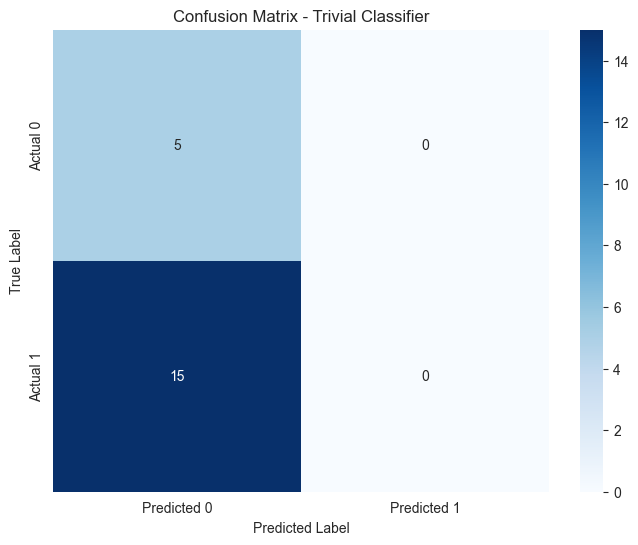

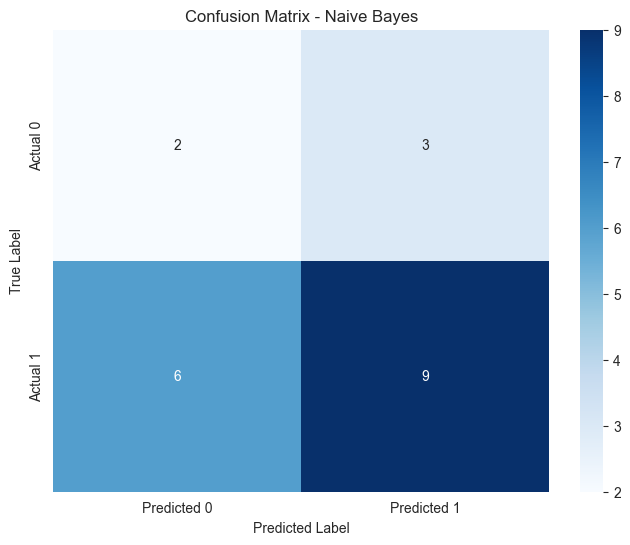

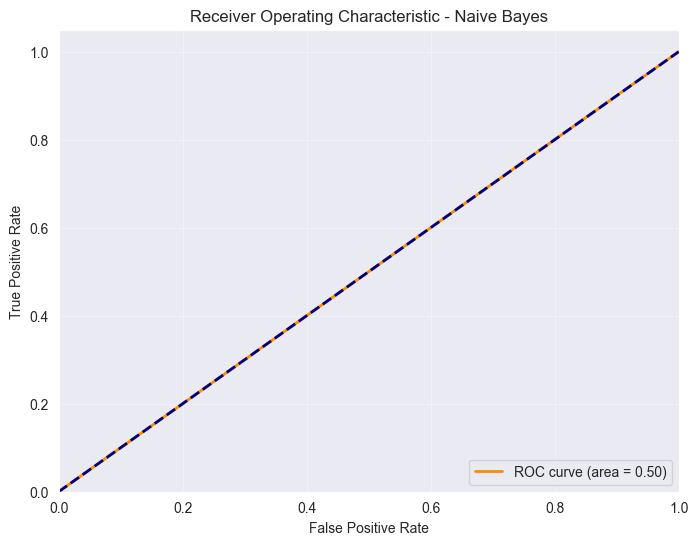

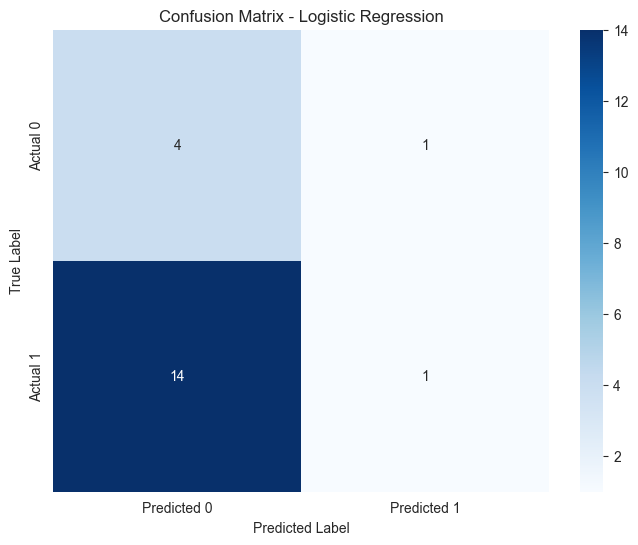

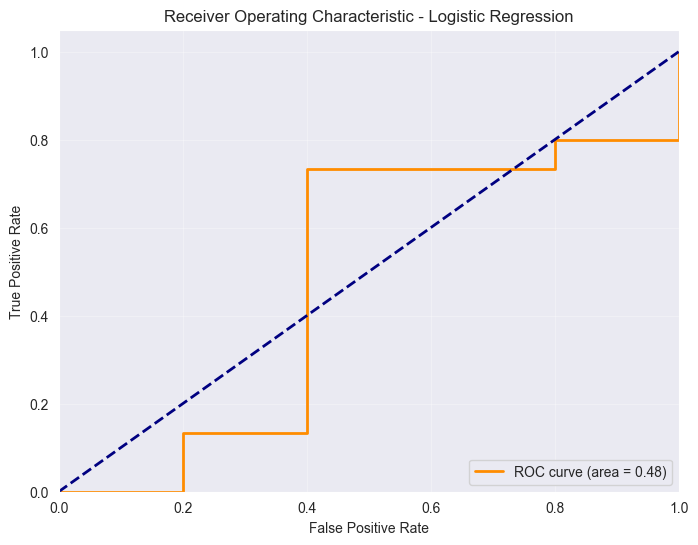

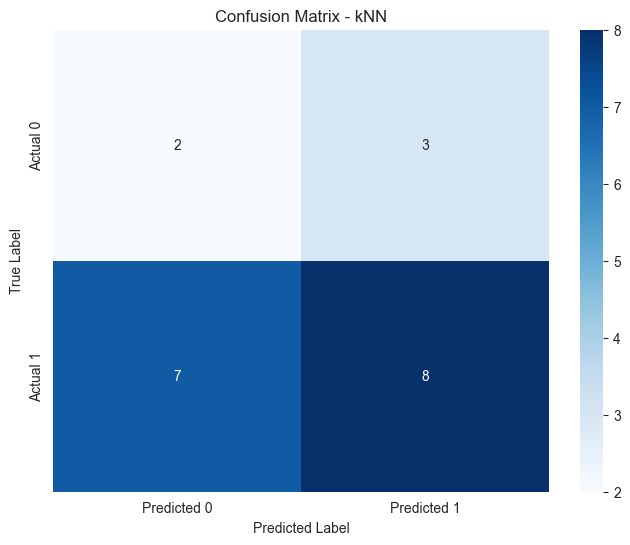

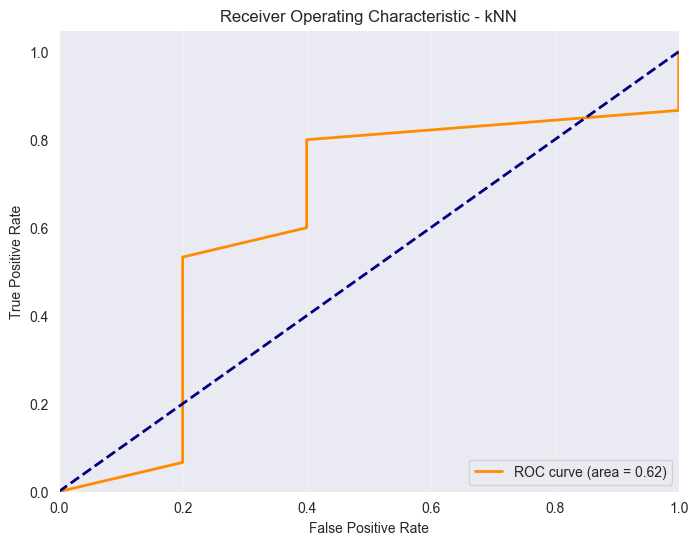

In [108]:
# Для тривиального классификатора
plot_confusion_matrix(y_test, y_pred_trivial, "Trivial Classifier")

# Для Наивного Байеса
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes")
if isinstance(y_pred_nb, np.ndarray) and np.issubdtype(y_pred_nb.dtype, np.integer):
    # Получаем вероятности для ROC AUC
    y_prob_nb = [nb._predict_single(x) for x in X_test.values]
    plot_roc_curve(y_test, y_prob_nb, "Naive Bayes")


# Для Логистической регрессии
plot_confusion_matrix(y_test, y_pred_logreg, "Logistic Regression")
y_prob_logreg = logreg.predict_proba(X_test.values)
plot_roc_curve(y_test, y_prob_logreg, "Logistic Regression")

# Для kNN
plot_confusion_matrix(y_test, y_pred_knn, "kNN")
if isinstance(y_pred_knn, np.ndarray) and np.issubdtype(y_pred_knn.dtype, np.integer):
    y_prob_knn = [knn.predict_proba(x) for x in X_test.values]
    plot_roc_curve(y_test, y_prob_knn, "kNN")

In [109]:
# Оценка качества моделей
def evaluate_model(y_true, y_pred, name):
    print(f"\n{name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    
    # ROC-AUC требует вероятностей
    if name != "Тривиальный классификатор":
        if name == "Наивный Байес":
            probs = [nb._predict_single(x) for x in X_test.values]
        elif name == "kNN":
            probs = [knn.predict_proba(x) for x in X_test.values]
        else:
            probs = logreg.predict_proba(X_test.values)
        roc_auc = roc_auc_score(y_true, probs)
        print(f"ROC-AUC: {roc_auc:.4f}")
    
    # Матрица ошибок
    print("Матрица ошибок:")
    print(confusion_matrix(y_true, y_pred))

In [110]:
# Оценка всех моделей
evaluate_model(y_test, y_pred_trivial, "Тривиальный классификатор")
evaluate_model(y_test, y_pred_nb, "Наивный Байес")


Тривиальный классификатор:
Accuracy: 0.2500
Precision: 0.0000
Recall: 0.0000
Матрица ошибок:
[[ 5  0]
 [15  0]]

Наивный Байес:
Accuracy: 0.5500
Precision: 0.7500
Recall: 0.6000
ROC-AUC: 0.5000
Матрица ошибок:
[[2 3]
 [6 9]]


In [111]:
evaluate_model(y_test, y_pred_knn, "kNN")
evaluate_model(y_test, y_pred_logreg, "Логистическая регрессия")


kNN:
Accuracy: 0.5000
Precision: 0.7273
Recall: 0.5333
ROC-AUC: 0.6200
Матрица ошибок:
[[2 3]
 [7 8]]

Логистическая регрессия:
Accuracy: 0.2500
Precision: 0.5000
Recall: 0.0667
ROC-AUC: 0.4800
Матрица ошибок:
[[ 4  1]
 [14  1]]
